# Deep Learning Lecture 3
## Where do we go from here?

1. **CNN Image intro <- we are here**
2. structured neural net intro
3. Language RNN intro
4. Collaborative filtering intro
5. Collaborative filtering indepth
6. Sturctureed nerual net in depth
7. CNN image in depth
8. Language RNN in depth 

### Talking about the Kaggle Command line - keeps changing though, be careful with different versions

Note: that the specific name of a kaggle is listed as follows:

https://www.kaggle.com/c/planet-understanding-the-amazon-from-space

Specific name:planet-understanding-the-amazon-from-space

Don't forget to pass

**curlWget Chrome extension** - everytime you try and download something. There's a yellow button with a command line version to download data. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/paperspace/repos/fastai')
import torch

In [3]:
import fastai

In [4]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

## 1. Comparison FASTAI : Short explanation on a quick and dirty Cats vs. Dogs. 

Need the following folders:

- Train - with a folder for different 
- Valid
- Test

#### Assuming you download from Kaggle and unzip

In [39]:
from fastai.conv_learner import *
PATH = 'data/dogscats/'

#### Set image size and batch size

In [6]:
sz = 224; bs = 64

### Training a model -> straight up 
##### Note: this command will download the resent model. May take a few minutes, using resnet 50 to compare to keras, will take about 10 mins to run afterwards

By default all the layers frozen except the last few. Note that we need to pass `test_name` parameter to ImageClassifierData for future predictions.

In [40]:
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms= tfms, bs=bs, test_name='test1')
learn = ConvLearner.pretrained(resnet50, data )
% time learn.fit( 1e-2, 3, cycle_len=1)

# deeper model like resnet 50 

A Jupyter Widget

[ 0.       0.04488  0.02685  0.99072]                         
[ 1.       0.03443  0.02572  0.99023]                         
[ 2.       0.04223  0.02662  0.99121]                         

CPU times: user 4min 16s, sys: 1min 43s, total: 5min 59s
Wall time: 6min 14s


#### Unfreeze the layers, apply a learning rate

**BN_freeze** - if are you using a deep network on a very similiar dataset to your target (ours is dogs and cats) - its causing the batch normalization not be updated

In [41]:
learn.unfreeze()
learn.bn_freeze(True)
%time learn.fit([1e-5, 1e-4,1e-2], 1, cycle_len=1)

A Jupyter Widget

[ 0.       0.02088  0.02454  0.99072]                         

CPU times: user 4min 1s, sys: 1min 5s, total: 5min 7s
Wall time: 5min 12s


#### Get the Predictions and score the model

In [42]:
%time log_preds, y = learn.TTA()
metrics.log_loss(y, np.exp(log_preds)), accuracy(log_preds,y)

CPU times: user 31.9 s, sys: 14 s, total: 45.9 s
Wall time: 56.2 s


(0.016504555816930676, 0.995)

### 2. Comparison FASTAI :  Keras Sample

#### Example running on Tensorflow backend

To install
```bash
pip install tensorflow-gpu keras 
```


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
from keras.preprocessing

In [ ]:
PATH = "data/dogscats/"
sz=224
batch_size=64

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

#### Set paths

In [ ]:
train_data_dir = f'{PATH}train'
validation_data_dir = f'{PATH}valid'
batch_size = 64

#### 1. Define a data generator(s)

- data augmentation do you want to do
- what kind of normalization do we want to do
- create images from directly looking at it
- create a generator - then generate images from a directory
- tell it what image size, whats the mini batch size you want
- do the same thing for the validation_generator, do it without shuffling, because then you can't track how well you are doing

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='binary')

# validation set
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
    shuffle=False,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='binary')

#### 2.  Make the Keras model
- Resnet 50 was because keras didnt have Resent34. This is for comparing apples to apples.
- Make base model
- make the layers manually which ones you want

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

#### 3. Loop through and freeze the layers you want 
- you need to compile the model
- pass the type of optimizer, loss, and metrics

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#### 4. Fit
- Keras expects the size per epoch
- how many workers
- batchsize

In [ ]:
%%time
model.fit_generator(train_generator, train_generator.n // batch_size, epochs=3, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

#### 6. We decide to retrain some of the layers, 
- loop through and manually set layers to true or false

In [ ]:
split_at = 140
for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])    

#### 7. Closing Comments

**Pytorch** - a little early for mobile deployment

**tensorflow** - do more work with keras, but can deploy out to other items, though you need to do a lot of work to get there. 


## 3. Reviewing Dogbreeds as an example to submit to Kaggle

#### how to make predictions - will use dogs / cats for simplicity. Jeremy uses Dogbreeds for walkthrough

by default pytorch gives back the log probability. 

In [43]:
log_preds,y = learn.TTA(is_test=True)
probs = np.exp(log_preds)

In [44]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [45]:
df.insert(0,'id', [o[5:-4] for o in data.test_ds.fnames])

In [46]:
df.head()

,id,cats,dogs
0,/828,0.000005,0.999994
1,/10093,0.979626,0.013680
2,/2205,0.999987,0.000010
3,/11812,0.000032,0.999559
4,/4042,0.000090,0.999901


In [49]:
SUBM = f'{PATH}sub/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}')

Gives you back a url that you can use to download onto your computer. For submissions, or file checking etc.

In [ ]:
FileLink(f'{SUBM}subm.gz')

## 4. What about a single prediction?

#### assign a single picture

In [50]:
fn = data.val_ds.fnames[0]

In [51]:
fn

'valid/cats/cat.9000.jpg'

#### can always view the photo

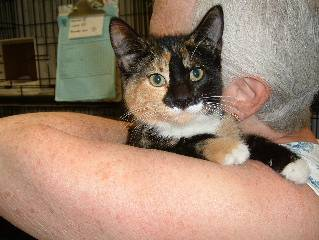

In [52]:
Image.open('data/dogscats/'+fn)

#### Shortest way to do a single prediction

Make sure you transform the image before submitting to the learn

```python
im = val_tfms(Image.open(PATH+fn)
learn.predict_array(im[none])
```

It's expecting a mini-batch or "tensors" so it should be a 4-d tensor. (#ct, height, weight, channels) This is why we add another dimension via `im[none]`

In [53]:
trn_tfms, val_tfms = tfms_from_model(resnet50,sz)

#### Predict dog or cat!

In [54]:
im = trn_tfms(Image.open('data/dogscats/'+fn))
preds = learn.predict_array(im[None])
np.argmax(preds) # 0 is cat

0

## 5. Convolution: Whats happening behind the scenes?

![](https://developer.apple.com/library/content/documentation/Performance/Conceptual/vImage/Art/kernel_convolution.jpg)

![](https://image.slidesharecdn.com/case-study-of-cnn-160501201532/95/case-study-of-convolutional-neural-network-3-638.jpg?cb=1462133741)

### Otavio's Video
google developer for the live version of translate fill in link here:

Shows the illustration of the image recognition of a letter A ( for classification)
Some highlights:

- Positives
- Negatives
- Max Pools
- Another Max Pools
- finally we compare it to a template of A,B,C,D,E, then we get a % probability
- illustrating a pretrained model

### Spreadsheet Example - Convolution Layers
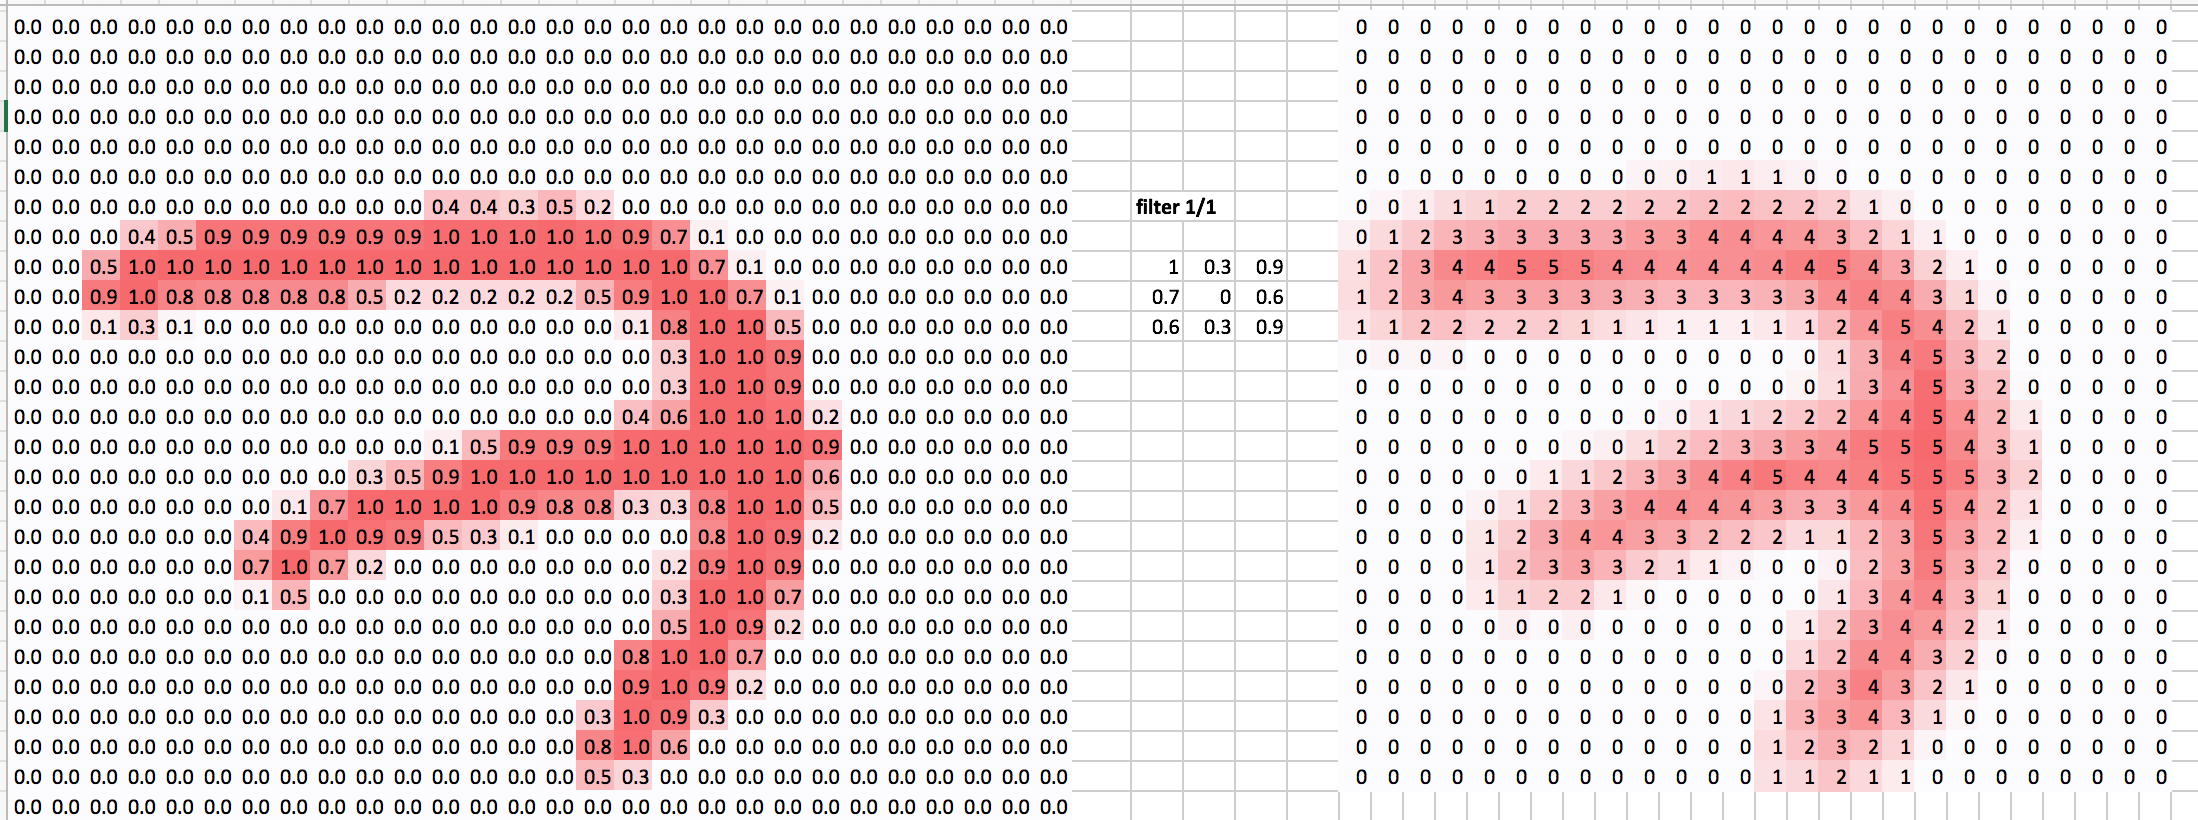

### Definitions 


|term | definitions|
|-----|------------|
|**Activations**|Input numbers x kernel matrix = numbers|
|**Relu**|MAX(0, calculated number)|
|**Filter / Kernel**| refers to the same thing, the 3x3 slice of a tensor|
|**tensor** | array with more dimensions. In this case, all these filters can be stacked into a multi-dimensional matrix.|
| **Hidden Layers** |intermediate calculation, not the input, and not the last layer, so called a hidden layer|
|**Architecture** | how big is your kernel and how many of them do you have ?|
|**Name your layers**| typically people will name their layers as they create it Conv1, Conv2 |
|**Max pooling**| a (2,2) max pooling will half the resolution in both height and width, as seen in the excel  |
|**Fully Connected Layer**| give every single activation and give them a weight. Then get a sum product of weights times activations. Really big weight matrix (sized as big as the entire import)  |
|**activation function** | is a function applied to activations. Max ( ) is an example |


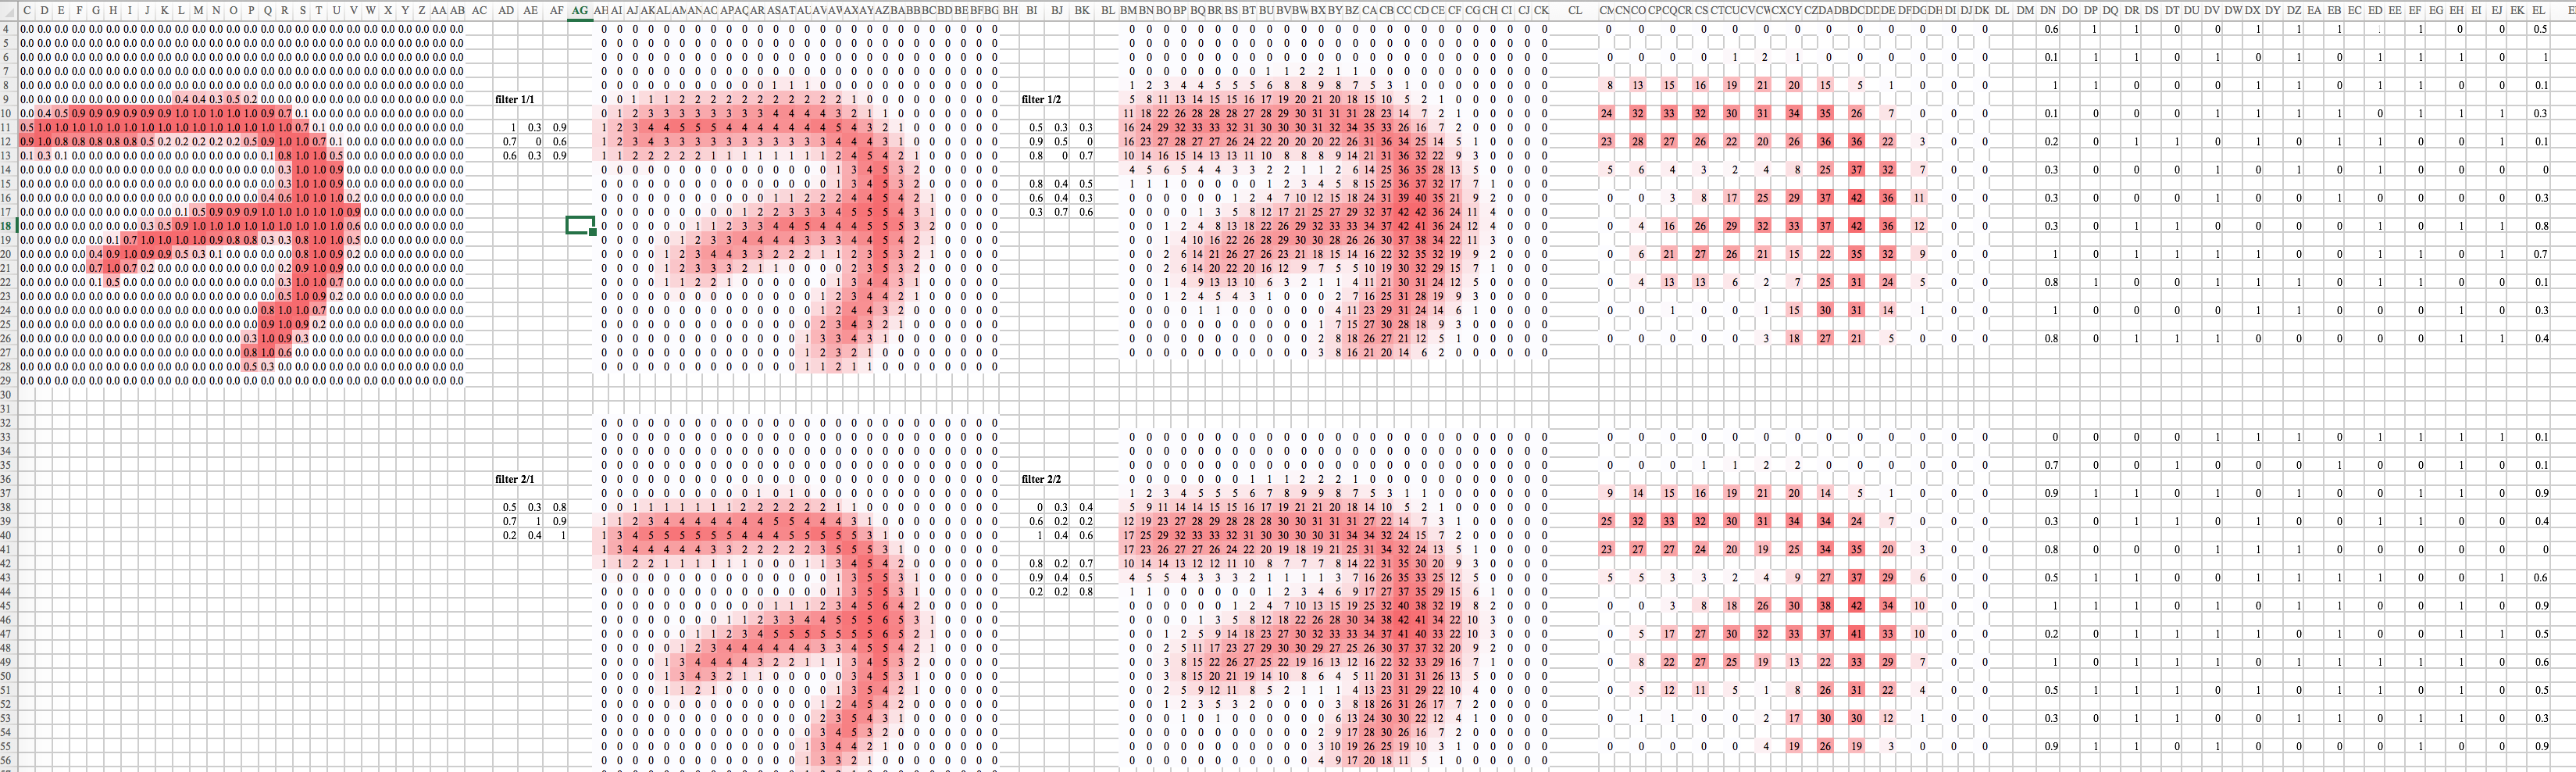

Layers
- Input
- Conv1
- Conv2
- Maxpool
- Denseweights
- Dense activation

### Example of Max pooling 
![](https://qph.ec.quoracdn.net/main-qimg-8afedfb2f82f279781bfefa269bc6a90)

![](https://s3-eu-west-1.amazonaws.com/com.cambridgespark.content/tutorials/convolutional-neural-networks-with-keras/figures/pool.png)

### Example of a softmax layer

Only ever occurs in the final layer. Always spits out numbers between 0 and 1. And the numbers added together gives us a total of 1. This isnt necessary, we COULD tell them to learn a kernel to give probabilities. But if you design your architecture properly, you will build a better model. If you build the model that way, and it iterates with the proper expected output you will save some time.

||output|exp|softmax|
|----|----|----|------|
|cat|4.84|126.44|0.40
|dog|3.98|53.60|0.17
|plane|4.89|132.48|0.42
|fish|-2.80|0.06|0.00
|building|-1.96|0.14|0.00
|Total||312.72|1.00 |

##### 1. Get rid of negatives
( Exponential column )

Some basic properties

$$ ln(xy) = ln(x) +ln(y)  $$
$$ ln\frac{x}{y} = ln(x)  - ln(y)  $$
$$ ln(x) = y , e^y = x $$

##### 2. then do the % proportion

$$ \frac{ln(x)}{\sum{ln(x)}} = probability$$


# Image models (how do we recognize multiple items?)

https://www.kaggle.com/c/planet-understanding-the-amazon-from-space

In [56]:
import sys
sys.path.append('/home/paperspace/repos/fastai')
import torch

In [57]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [58]:
PATH = '/home/paperspace/Desktop/data/Planet: Understanding the Amazon from Space/'

In [59]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
#plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

##### f2 = is f_beta where beta = 2, weights false negatives and false positives much worse

In [60]:
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

In [62]:
#from planet import f2

metrics=[f2]

### Write any metric you like


##### Custom metrics from the `planet.py` file

```python

from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]

def get_data(path, tfms,bs,  n, cv_idx):
    val_idxs = get_cv_idxs(n, cv_idx)
    return ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms,
                                 suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

def get_data_zoom(f_model, path, sz, bs, n, cv_idx):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return get_data(path, tfms, bs, n, cv_idx)

def get_data_pad(f_model, path, sz, bs, n, cv_idx):
    transforms_pt = [RandomRotateZoom(9, 0.18, 0.1), RandomLighting(0.05, 0.1), RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_pt, pad=sz//12)
    return get_data(path, tfms, bs, n, cv_idx)
````

In [63]:
f_model = resnet34

In [64]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [65]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [66]:
PATH = '/home/paperspace/Desktop/data/Planet: Understanding the Amazon from Space/'

In [67]:
os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('cache/planet/tmp', exist_ok=True)


In [68]:
label_csv = f'{PATH}train_v2.csv'


In [69]:
data = get_data(256)

In [70]:
x,y = next(iter(data.val_dl))

In [71]:
y


    1     0     0  ...      0     1     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.FloatTensor of size 64x17]

In [72]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 1.0),
 ('water', 1.0)]

### One Hot Encoding:

|Classification | softmax | dog (one-hot) | Index | sigmoid |
|-----| -----|------|---|----|
| cat |  0 |  0 | 0 | 0.01 |
| dog | 0.92 | 1 | 1 | 0.98 |
| plane | 0 | 0  | 2 | 0.01 |
| fish | 0 | 0 | 3 | 0.0 |
| building| 0.08 | 0 |4  | 0.07 |

#### Softmax - probabilities to make 1 choice

#### one-hot - each column only tracks 1 possible classification. e.g. 3 classes = 3 columns

#### Index - multi class stored as indices. Taken care of by FastAI library

#### Sigmoid function

$$ = \frac{e^\alpha}{1+e^\alpha}$$

![](https://cdn-images-1.medium.com/max/1600/1*sOtpVYq2Msjxz51XMn1QSA.png)

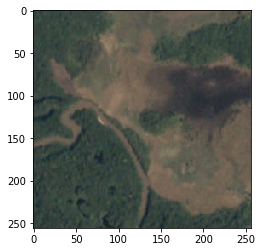

In [31]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

# How do we use this?

### resize the data from 256 down to 64 x 64. 

Wouldnt do this for cats and dogs, beacuse it starts off nearly perfect. If we resized, we destroy the model. Most Imagenet models are designed around 224 which was close to the normal. In this case, since this is landscape, there isn't that much of Imagenet that is useful for satellite. 

##### So we will start small

In [73]:
sz=64

In [74]:
data = get_data(sz)

#### What does resize do?

I will not use images more than image size 1.3, go ahead and make new jpg where the smallest edge is x size. So this will save a lot of time for processing. In general the image resize will take a center crop

In [75]:
data = data.resize(int(sz*1.3), 'tmp')

A Jupyter Widget

#### Train our model

In [76]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

#### To view the model + the layers (only looking at 5)

In [90]:
list(learn.summary().items())[:5]

[('Conv2d-1',
  OrderedDict([('input_shape', [-1, 3, 64, 64]),
               ('output_shape', [-1, 64, 32, 32]),
               ('trainable', False),
               ('nb_params', 9408)])),
 ('BatchNorm2d-2',
  OrderedDict([('input_shape', [-1, 64, 32, 32]),
               ('output_shape', [-1, 64, 32, 32]),
               ('trainable', False),
               ('nb_params', 128)])),
 ('ReLU-3',
  OrderedDict([('input_shape', [-1, 64, 32, 32]),
               ('output_shape', [-1, 64, 32, 32]),
               ('nb_params', 0)])),
 ('MaxPool2d-4',
  OrderedDict([('input_shape', [-1, 64, 32, 32]),
               ('output_shape', [-1, 64, 16, 16]),
               ('nb_params', 0)])),
 ('Conv2d-5',
  OrderedDict([('input_shape', [-1, 64, 16, 16]),
               ('output_shape', [-1, 64, 16, 16]),
               ('trainable', False),
               ('nb_params', 36864)]))]

#### Search for Learning Rate

In [93]:
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 0.2

#### Refit the model

Follow the last few steps on the bottom of the python notebook
https://github.com/fastai/fastai/blob/master/courses/dl1/lesson2-image_models.ipynb

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

#### How are the learning rates spread per  layer?
[ split halfway, split halfway , always last layer only]

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.sched.plot_loss()

## Structured Data

https://www.kaggle.com/c/favorita-grocery-sales-forecasting

There's really two types of data. Unstructured and structured data. Structured data - columnar data, columns, etc.. Structured data is important in the world, but often ignored by academic people. Will look at the rossman stores data

https://www.kaggle.com/c/rossmann-store-sales

In [6]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [7]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.structured import *
from fastai.dataset import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
import operator

PATH='/home/paperspace/Desktop/data/rossman/'

In [8]:
test = pd.read_csv(f'{PATH}test.csv', parse_dates=['Date'])

In [9]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob.glob(f"{path}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [12]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [13]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [14]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

### Next Week - Data prep and transformations